# Lab 1, EV Charging Stations Data analysis

Team Members: Sandro Juric & Scotty Seethoff

### AI usage disclaimer
We have used the Copilot in this project, primarily for code refactoring in VS Code

# Business Understanding

Driving pure electric vehicles comes with new challenges that new and existing consumers face. Of those range anxiety is the most significant hurdle that EV driver faces in most countries. A common issue with most electric vehicles is that they typically need to be recharged after around two hundred miles of driving. While many EV drivers have home charging stations, the problem apperent during road trips. 

Therefore, having charging stations available becomes paramount to a successful road trip experience in an EV car. There are four main factors to consider when dealing with EV charging stations. Firstly, are there any charging stations available in the area where you will be driving? Secondly, do those available stations support fast DC charging and which rate can you expect the output to be? Next, do the available charging station support the type of charging connector you can have? Finally, are the stations available in good working conditions, or mostly offline?

The dataset analysed is for the global EV charging stations and will describe the state of each country EV infrastructure. Real-time data from 123 active countries, spanning 2010 to 2026, has been gathered to illustrate the growth of electric vehicles and assess the reliability of individual stations. Along with geographic data, the data includes station status, maximum power output, available connectors, and which year it was created.

My hypothesis is that the global EV infrastructure has grown significantly over the years and that will continue to grow in the decades to come. With the analysis we will explore if that is the case and what countries have reached a critical density of reliable EV station for an everyday consumer to feel comfortable driving anywhere in their EV without extensive planning.

Dataset: https://www.kaggle.com/datasets/sohails07/global-ev-charging-station-network-2010-2026

Questions we are seeking to answers:

1. Which global regions have enough EV chargers?
2. Has the EV charging infrastructure rollout increase over time year over year?
3. Which countries has made most progress?

# Data Understanding

In [2]:
import pandas as pd
import numpy as np

# Suppress SettingWithCopyWarning
pd.options.mode.chained_assignment = None  # default='warn'
# Ensure future behavior for downcasting is explicit
pd.set_option('future.no_silent_downcasting', True)

df = pd.read_csv('global_ev_charging_station.csv')

# select relevant columns
dfSelect = df[['StationID', 'Country', 'Town', 'Latitude', 'Longitude', 'MaxPowerKW', 'ConnectionTypes', 'StatusType', 'YearCreated']]

# remap connection types to broader categories
connection_type_map = {
    'CHAdeMO': 'Fast',
    'CCS (Type 1)': 'Fast',
    'CCS (Type 2)': 'Fast',
    'Tesla Supercharger': 'Fast',
    'Type 2': 'Standard',
    'Type 1': 'Standard',
    'J1772': 'Standard',
    'GB/T': 'Fast',
    'Schuko': 'Slow',
    'Ceeform (Blue)': 'Slow',
    'Ceeform (Red)': 'Slow'
}


dfSelect['ConnectionTypes'] = dfSelect['ConnectionTypes'].map(connection_type_map).fillna('Other')

# remap status types to simplified categories
status_type_map = { 
    'Operational': True,
    'Under Construction': False,
    'Planned': False,
    'Temporarily Unavailable': False,
    'Removed': False
}

# convert StatusType to boolean
dfSelect['StatusType'] = dfSelect['StatusType'].map(status_type_map).astype('bool', errors='ignore')

# handle missing values for Town and Country

# Impute the town using the country
dfSelect['Town'] = dfSelect.groupby('Country')['Town'].transform(
    lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else x)
)

# Impute Town based on most common Town within each Country
dfSelect['Town'] = dfSelect.groupby('Country')['Town'].transform(
    lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else 'Unknown')
)

# Impute City based on most common City within each Country
dfSelect['Town'] = dfSelect.groupby('Country')['Town'].transform(
    lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else 'Unknown')
)

#if that doesn't work, just fallback to 'Unknown' for any remaining missing values
dfSelect['Town'] = dfSelect['Town'].fillna('Unknown')
dfSelect['Country'] = dfSelect['Country'].fillna('Unknown')

# rename columns for clarity
dfSelect.rename(columns={
    'Town': 'City', 
    'MaxPowerKW': 'Rate', 
    'YearCreated': 'Built', 
    'ConnectionTypes': 'Charge Rate', 
    'StatusType': 'Is Online', 
    'Latitude': 'Lat', 
    'Longitude': 'Long', 
    'StationID':'Station ID'}, inplace=True)

# format and display of the first few rows
# used the pandas Styler for better visualization in Jupyter Notebooks https://pandas.pydata.org/docs/user_guide/style.html
display(dfSelect.head(10).style.background_gradient(axis=None, cmap="YlGnBu"))

,Station ID,Country,City,Lat,Long,Rate,Charge Rate,Is Online,Built
0,473101,United Kingdom,London,51.371709,-0.116955,250.000000,Fast,True,2026
1,472908,United Kingdom,Wythenshawe,53.366453,-2.269799,11.000000,Other,True,2026
2,472220,United Kingdom,Belfast,54.586836,-5.926869,50.000000,Fast,True,2025
3,471954,United Kingdom,Dungannon,54.509453,-6.768057,22.000000,Other,True,2025
4,471953,United Kingdom,Armagh,54.350644,-6.641787,22.000000,Other,True,2025
5,471952,United Kingdom,Armagh,54.349971,-6.642684,22.000000,Other,True,2025
6,471951,United Kingdom,Craigavon,54.435689,-6.411357,22.000000,Other,True,2025
7,471950,United Kingdom,Portadown,54.433089,-6.410223,22.000000,Other,True,2025
8,471949,United Kingdom,Lurgan,54.456608,-6.338349,22.000000,Other,True,2025
9,471948,United Kingdom,Rathfriland,54.236068,-6.162224,22.000000,Other,True,2025


### Data Cleanup
Picked the relavent features for analysis and discarded rest. Mapped over Charge Rate based on common known mapping and set unknown data to "Other". Mapped over the operational status to boolean, it's either online or not.  Renamed columns for easer read and formated the output.

In [3]:
dfSelect.info()


print("\n")
print("Data Summary Statistics:")

# Display summary statistics
display(dfSelect.describe(include='all'))

# Display number of records with unknown values with percentages
unknown_cities_count = dfSelect[dfSelect['City'] == 'Unknown'].shape[0]
print(f"Number of records with unknown cities: {unknown_cities_count} ({unknown_cities_count / len(dfSelect) * 100:.2f}%)")

unknown_countries_count = dfSelect[dfSelect['Country'] == 'Unknown'].shape[0]
print(f"Number of records with unknown countries: {unknown_countries_count} ({unknown_countries_count / len(dfSelect) * 100:.2f}%)")

unknown_connection_types_count = dfSelect[dfSelect['Charge Rate'] == 'Unknown'].shape[0]
print(f"Number of records with 'Unknown' connection types: {unknown_connection_types_count} ({unknown_connection_types_count / len(dfSelect) * 100:.2f}%)")

offline_stations_count = dfSelect[dfSelect['Is Online'] == False].shape[0]
print(f"Number of offline stations: {offline_stations_count} ({offline_stations_count / len(dfSelect) * 100:.2f}%)")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257585 entries, 0 to 257584
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Station ID   257585 non-null  int64  
 1   Country      257585 non-null  object 
 2   City         257585 non-null  object 
 3   Lat          257585 non-null  float64
 4   Long         257585 non-null  float64
 5   Rate         257585 non-null  float64
 6   Charge Rate  257585 non-null  object 
 7   Is Online    257585 non-null  bool   
 8   Built        257585 non-null  int64  
dtypes: bool(1), float64(3), int64(2), object(3)
memory usage: 16.0+ MB


Data Summary Statistics:


,Station ID,Country,City,Lat,Long,Rate,Charge Rate,Is Online,Built
count,257585.000000,257585,257585,257585.000000,257585.000000,257585.000000,257585,257585,257585.000000
unique,NaN,123,43777,NaN,NaN,NaN,2,2,NaN
top,NaN,United States,Paris,NaN,NaN,NaN,Other,True,NaN
freq,NaN,86904,10823,NaN,NaN,NaN,240001,252412,NaN
mean,214027.344244,NaN,NaN,43.024583,-32.331054,36.094556,NaN,NaN,2021.177984
std,112354.931522,NaN,NaN,13.060504,57.567388,1971.171374,NaN,NaN,3.404048
min,2389.000000,NaN,NaN,-55.811599,-164.848855,0.000000,NaN,NaN,2010.000000
25%,127474.000000,NaN,NaN,38.785981,-81.528641,3.700000,NaN,NaN,2019.000000
50%,213775.000000,NaN,NaN,44.293968,-3.117260,11.000000,NaN,NaN,2023.000000
75%,289084.000000,NaN,NaN,51.343085,7.690003,22.000000,NaN,NaN,2024.000000


Number of records with unknown cities: 2 (0.00%)
Number of records with unknown countries: 0 (0.00%)
Number of records with 'Unknown' connection types: 0 (0.00%)
Number of offline stations: 5173 (2.01%)


### Data Analysis

Unknown city in data is only 2 and we still have long & lat data for those records so these can be safely ignored as mapping it can still be done to a map.

There are no unknown countries and the number of offline station is statistically insignificant to matter for the final analysis so we can ignore those.

In [4]:
#Cleaning
df.columns = df.columns.str.strip()

dfSelect = df[
    ["StationID", "Country", "Town", "Latitude", "Longitude", "MaxPowerKW", "StatusType", "YearCreated", "ConnectionTypes"]
].copy()

# had to rename it again to what we named it in the previous cell to make it work
dfSelect.rename(columns={
    "StationID": "Station ID",
    "Town": "City",
    "Latitude": "Lat",
    "Longitude": "Long",
    "MaxPowerKW": "Rate",
    "StatusType": "Is Online",
    "YearCreated": "Built",
    "ConnectionTypes": "ConnectionTypes"  
}, inplace=True)

# raw connector column
RAW_CONNECTION_COL = "ConnectionTypes"
DERIVED_COL = "Charge Rate"   

# Inspect raw values 
unique_connection_types = (
    dfSelect[RAW_CONNECTION_COL]
    .dropna()
    .astype(str)
    .unique()
)

print("Total number of unique raw connection strings:", len(unique_connection_types))
print("Sample raw connection strings:")
print(unique_connection_types[:10])

# Categorizing function
def categorize_connection_type(connection_types):
    if pd.isna(connection_types):
        return "Unknown"

    # Use substring matching to catch variants
    fast_types = [
        "CCS", "CHADEMO", "SUPERCHARGER", "NACS",
        "GB-T DC", "GB/T 20234.3", "CHAOJI"
    ]
    standard_types = [
        "TYPE 1", "TYPE 2", "J1772", "TESLA",
        "GB-T AC", "GB/T 20234.2", "TYPE I", "TYPE II"
    ]
    slow_types = [
        "SCHUKO", "CEE", "BS1363", "EUROPLUG",
        "NEMA", "IEC 60309", "SCAME", "3 PIN", "WIRELESS"
    ]

    raw = str(connection_types).upper().replace(";", ",")
    connectors = [c.split("(")[0].strip() for c in raw.split(",") if c.strip()]

    # Fast Standard Slow
    if any(any(f in c for f in fast_types) for c in connectors):
        return "Fast"
    if any(any(s in c for s in standard_types) for c in connectors):
        return "Standard"
    if any(any(s in c for s in slow_types) for c in connectors):
        return "Slow"
    return "Unknown"

dfSelect[DERIVED_COL] = dfSelect[RAW_CONNECTION_COL].apply(categorize_connection_type)

# Validation
dist = dfSelect[DERIVED_COL].value_counts(normalize=True).mul(100).round(2)
print("\nCharge Rate distribution (%):")
print(dist)

unknown_samples = (
    dfSelect.loc[dfSelect[DERIVED_COL] == "Unknown", RAW_CONNECTION_COL]
    .dropna()
    .astype(str)
    .unique()[:10]
)

print("\nSample Unknown raw strings after mapping:")
print(unknown_samples)

Total number of unique raw connection strings: 474
Sample raw connection strings:
['CCS (Type 2)' 'Type 2 (Socket Only)'
 'CCS (Type 2), Type 2 (Socket Only)' 'Type 2 (Tethered Connector)'
 'CCS (Type 2), CHAdeMO' 'CCS (Type 1)'
 'CCS (Type 2), CHAdeMO, Type 2 (Tethered Connector)' 'CHAdeMO'
 'CCS (Type 2), CHAdeMO, Type 2 (Socket Only)' 'BS1363 3 Pin 13 Amp']

Charge Rate distribution (%):
Charge Rate
Standard    71.10
Fast        24.66
Slow         2.24
Unknown      2.00
Name: proportion, dtype: float64

Sample Unknown raw strings after mapping:
['Blue Commando (2P+E)' 'SP Inductive' 'Avcon Connector' 'LP Inductive'
 'Three Phase 5-Pin (AS/NZ 3123)' 'Type M'
 'T13 - SEC1011 ( Swiss domestic 3-pin ) - Type J']


# Data Visualization

Mapping the charging station to a global map, first for all EV chargers regardless of speed and then for the fast chargers. 

Text(0.5, 1.0, 'Global Distribution of Fast EV Charging Stations')

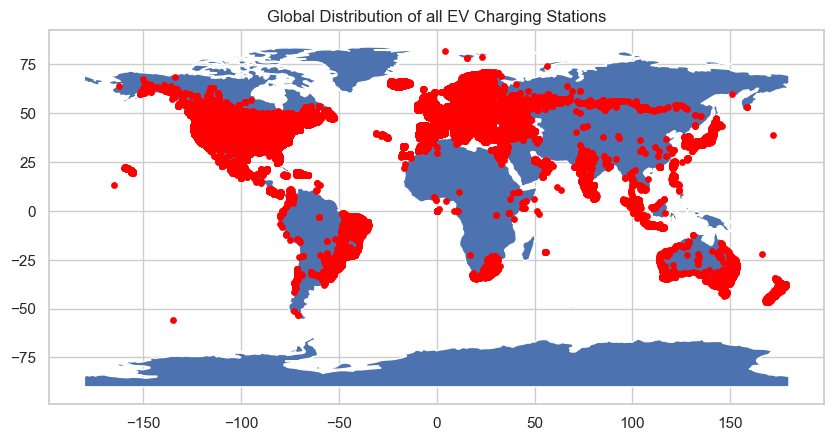

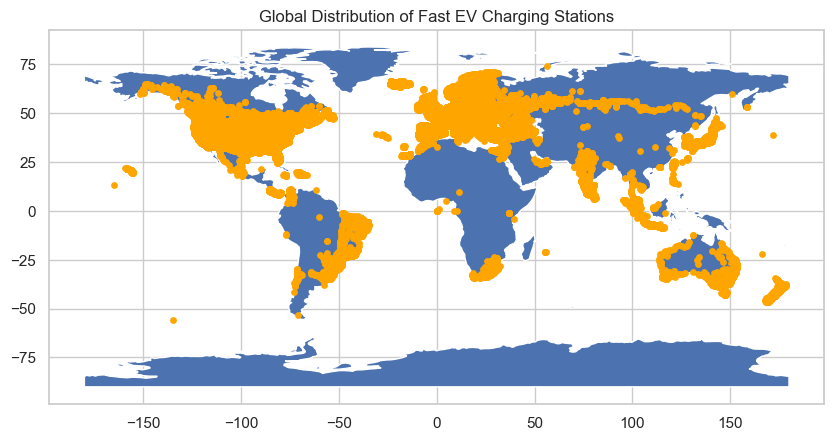

In [40]:
#importing these for the mapping to global map
from shapely.geometry import Point
import geopandas as gpd
import geodatasets

#create world map of station density

geometry = [Point(xy) for xy in zip(dfSelect['Long'], dfSelect['Lat'])]

gdf = gpd.GeoDataFrame(dfSelect, geometry=geometry)
world = gpd.read_file(geodatasets.data.naturalearth.land['url'])

gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=15).set_title('Global Distribution of all EV Charging Stations')


dfSelectFast = dfSelect[(dfSelect['Charge Rate'] == 'Fast')]
geometry = [Point(xy) for xy in zip(dfSelectFast['Long'], dfSelectFast['Lat'])]

gdf = gpd.GeoDataFrame(dfSelectFast, geometry=geometry)
world = gpd.read_file(geodatasets.data.naturalearth.land['url'])

gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='orange', markersize=15).set_title('Global Distribution of Fast EV Charging Stations')

### Analysis

By looking at the two global maps below we can deduced that the EV charing density is well saturated in North America and Europe, the significant coverage in South America, Austrilia and East Asia. However most of Afica, with exception of South Afica has no coverage and West Asia with the execption of India and Persian Gulf contries has limited or no coverage.  This alone allowed us to answer one of the questions the next charts are regarding the second questions.

We used charts from ([Python Code Examples/charts and tables](../HOWTOs/charts_and_tables.ipynb)) for code samples.

Year range used: 2010 to 2026
Total records used: 257585

Top countries by recent growth trend:


,index,Country,Slope,Total_Stations
110,110,United States,1816.028571,86904
15,15,Canada,1344.100000,18802
23,23,Denmark,213.300000,2200
60,60,Lithuania,135.100000,964
88,88,Russian Federation,110.200000,2264
41,41,India,90.771429,1246
45,45,Ireland,38.571429,2284
12,12,Brazil,37.942857,916
63,63,Malaysia,33.942857,714
107,107,Ukraine,33.800000,569


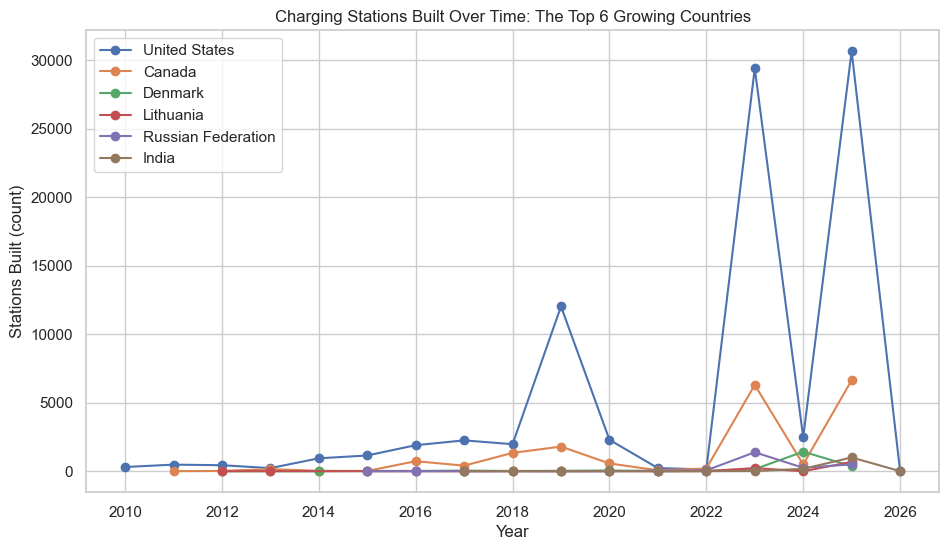


Continent counts:
Continent
Europe           137940
North America    106928
Asia               5675
Oceania            2256
Other/Unknown      2142
South America      1452
Africa             1192
Name: count, dtype: int64


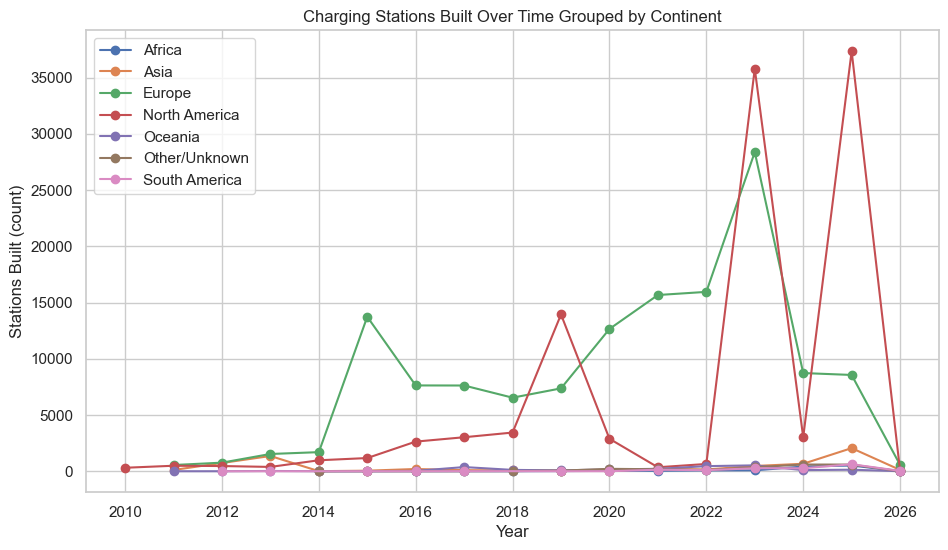

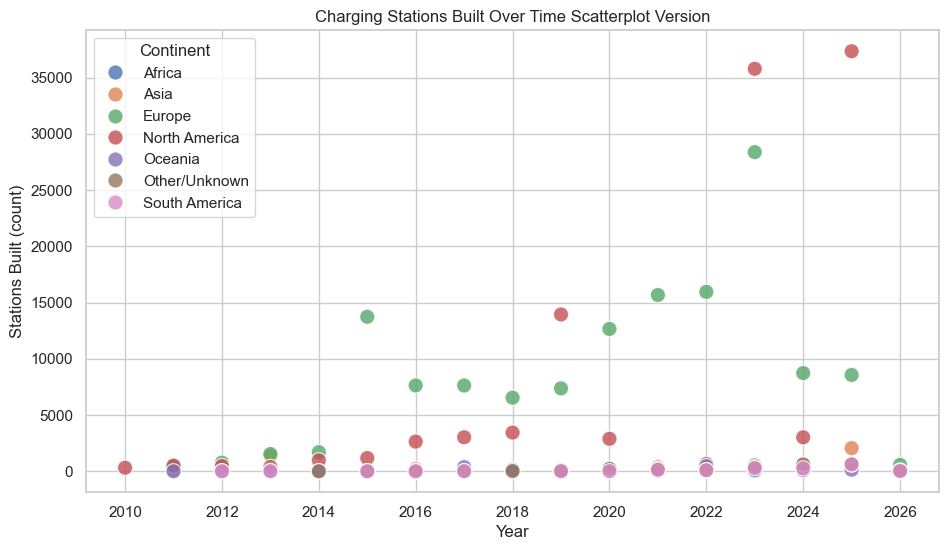


Countries not mapped to a continent (first 25 shown):
['Aland Islands', 'Iran; Islamic Republic Of', 'Korea; Republic Of', 'Kosovo', 'Macedonia', 'Moldova; Republic Of', 'Reunion', 'Swaziland', 'Taiwan; Province Of China', 'Turkey']

Top countries by station count:


,Station_Count,Unique_Charger_Types,Percent_of_Total_Stations
Country,,,
United States,86904,20.0,33.74
United Kingdom,27478,15.0,10.67
Germany,24498,16.0,9.51
Spain,19366,15.0,7.52
Canada,18802,11.0,7.30
France,15139,16.0,5.88
Italy,10496,17.0,4.07
Netherlands,8128,15.0,3.16
Sweden,4962,12.0,1.93



Top countries by unique charger types:


,Station_Count,Unique_Charger_Types,Percent_of_Total_Stations
Country,,,
United States,86904,20.0,33.74
Russian Federation,2264,17.0,0.88
Italy,10496,17.0,4.07
Germany,24498,16.0,9.51
France,15139,16.0,5.88
Belgium,1267,16.0,0.49
Netherlands,8128,15.0,3.16
Austria,1325,15.0,0.51
Spain,19366,15.0,7.52


Pearson correlation (r): 0.531
P-value: 1e-05
Regression line: y = 0.0002x + 8.4707


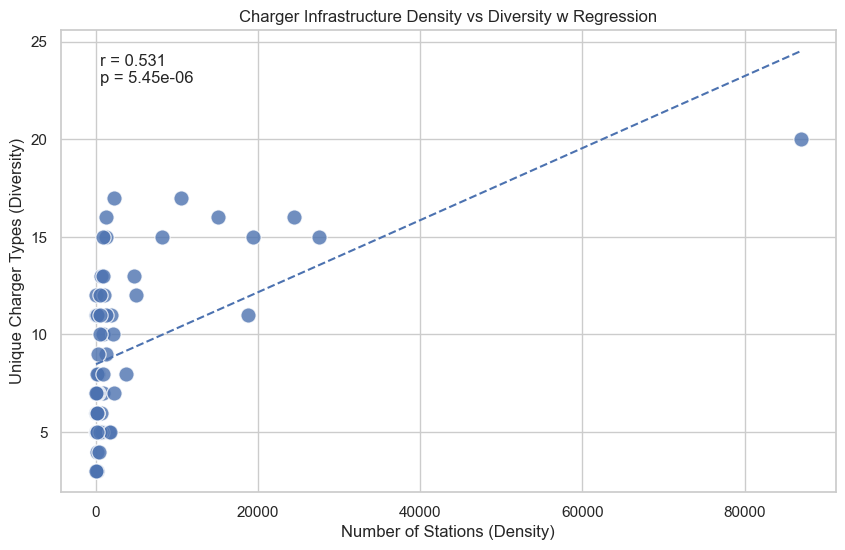

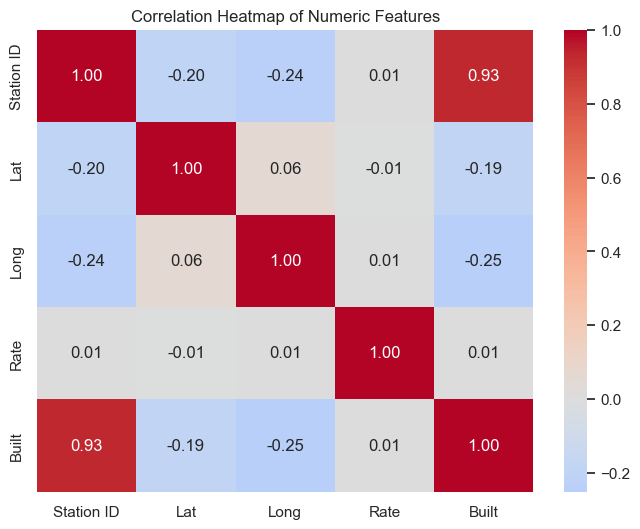

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#importing this to help with mapping countries to continents
import pycountry
import pycountry_convert as pc


from scipy.stats import pearsonr

sns.set_theme(style="whitegrid")

# Figure out which column represents the year stations were built
YEAR_COL = "Built" if "Built" in dfSelect.columns else ("YearCreated" if "YearCreated" in dfSelect.columns else None)
if YEAR_COL is None:
    raise KeyError("We need a year column like 'Built' or 'YearCreated' in dfSelect.")

if "Country" not in dfSelect.columns:
    raise KeyError("We need a 'Country' column in dfSelect.")


#data cleaingn
df_time = dfSelect.copy()

df_time[YEAR_COL] = pd.to_numeric(df_time[YEAR_COL], errors="coerce")
df_time = df_time.dropna(subset=[YEAR_COL, "Country"]).copy()
df_time[YEAR_COL] = df_time[YEAR_COL].astype(int)
#2010 to the current year
df_time = df_time[(df_time[YEAR_COL] >= 2010) & (df_time[YEAR_COL] <= 2026)].copy()

print("Year range used:", df_time[YEAR_COL].min(), "to", df_time[YEAR_COL].max())
print("Total records used:", len(df_time))


#stations built per country every year
country_year = (
    df_time.groupby(["Country", YEAR_COL])
    .size()
    .reset_index(name="Station_Count")
)


# growing fastest recently
RECENT_YEARS = 6
max_year = int(df_time[YEAR_COL].max())
min_recent_year = max_year - (RECENT_YEARS - 1)

recent = country_year[country_year[YEAR_COL] >= min_recent_year].copy()

def slope_over_time(group: pd.DataFrame) -> float:
    x = group[YEAR_COL].to_numpy()
    y = group["Station_Count"].to_numpy()
    if len(np.unique(x)) < 2:
        return 0.0
    return float(np.polyfit(x, y, 1)[0])

country_slopes = (
    recent.groupby("Country", as_index=False)
    .apply(slope_over_time, include_groups=False)
    .reset_index()
)

# Cleaning up column names
if country_slopes.shape[1] == 2:
    country_slopes.columns = ["Country", "Slope"]
else:
    country_slopes = country_slopes.rename(columns={country_slopes.columns[-1]: "Slope"})

# Filter out countries with very small infrastructure
MIN_TOTAL_STATIONS = 200
total_by_country = df_time.groupby("Country").size()

country_slopes["Total_Stations"] = country_slopes["Country"].map(total_by_country)
country_slopes = country_slopes[country_slopes["Total_Stations"] >= MIN_TOTAL_STATIONS].copy()

country_slopes = country_slopes.sort_values("Slope", ascending=False)

print("\nTop countries by recent growth trend:")
display(country_slopes.head(10))

# Plot showing growth over time for the fastest growing countries
TOP_N = 6
top_countries = country_slopes.head(TOP_N)["Country"].tolist()

plt.figure(figsize=(11, 6))
for c in top_countries:
    sub = country_year[country_year["Country"] == c].sort_values(YEAR_COL)
    plt.plot(sub[YEAR_COL], sub["Station_Count"], marker="o", label=c)

plt.title(f"Charging Stations Built Over Time: The Top {TOP_N} Growing Countries")
plt.xlabel("Year")
plt.ylabel("Stations Built (count)")
plt.legend()
plt.show()

#making a continent map array to group countries by continent
continent_names = {
    "AF": "Africa",
    "AS": "Asia",
    "EU": "Europe",
    "NA": "North America",
    "SA": "South America",
    "OC": "Oceania"
}

#have to manually correct some of the names from the dataset so they match the pycountry library for continent mapping
country_corrections = {
    "United States": "United States of America",
    "Czech Republic": "Czechia",
    "Palestinian Territory; Occupied": "Palestine, State of",
   #not sure why these aren't working
   # "Iran": "Iran; Islamic Republic Of",
   # "Korea; Republic Of": "Korea; Republic Of",
   # "Moldova": "Moldova; Republic Of",
   # "Taiwan": "Taiwan; Province Of China",
}

def country_to_continent(country_name: str) -> str:
    try:
        name = country_corrections.get(str(country_name), str(country_name))
        country = pycountry.countries.lookup(name)
        continent_code = pc.country_alpha2_to_continent_code(country.alpha_2)
        return continent_names.get(continent_code, "Other/Unknown")
    except Exception:
        return "Other/Unknown" #just in case I missed anything

df_time["Continent"] = df_time["Country"].apply(country_to_continent)

print("\nContinent counts:")
print(df_time["Continent"].value_counts())

#growth patterns grouped by continent
continent_year = (
    df_time.groupby(["Continent", YEAR_COL])
    .size()
    .reset_index(name="Station_Count")
)

plt.figure(figsize=(11, 6))
for cont in sorted(continent_year["Continent"].unique()):
    sub = continent_year[continent_year["Continent"] == cont].sort_values(YEAR_COL)
    plt.plot(sub[YEAR_COL], sub["Station_Count"], marker="o", label=cont)

plt.title("Charging Stations Built Over Time Grouped by Continent")
plt.xlabel("Year")
plt.ylabel("Stations Built (count)")
plt.legend()
plt.show()

continent_year = (
    df_time.groupby(["Continent", YEAR_COL])
    .size()
    .reset_index(name="Station_Count")
)

# Scatterplot
plt.figure(figsize=(11, 6))
sns.scatterplot(
    data=continent_year,
    x=YEAR_COL,
    y="Station_Count",
    hue="Continent",
    s=120,
    alpha=0.8
)
plt.title("Charging Stations Built Over Time Scatterplot Version")
plt.xlabel("Year")
plt.ylabel("Stations Built (count)")
plt.legend(title="Continent", loc="best")
plt.show()

unmapped = sorted(
    df_time.loc[df_time["Continent"] == "Other/Unknown", "Country"].unique().tolist()
)

print("\nCountries not mapped to a continent (first 25 shown):")
print(unmapped[:25])

if "ConnectionTypes" not in dfSelect.columns:
    raise KeyError("Need 'ConnectionTypes' in dfSelect for charger-type analysis.")

df_types = dfSelect[["Country", "ConnectionTypes"]].dropna().copy()

# Split multiple connectors into separate rows
df_types["ConnectionTypes"] = (
    df_types["ConnectionTypes"]
    .astype("string")
    .str.replace(";", ",", regex=False)
    .str.split(",")
)
df_types = df_types.explode("ConnectionTypes")
df_types["ConnectionTypes"] = df_types["ConnectionTypes"].str.strip()

# How many unique charger types each country supports
charger_types_per_country = (
    df_types.groupby("Country")["ConnectionTypes"]
    .nunique()
    .sort_values(ascending=False)
)

# Density number of stations in each country
stations_per_country = (
    dfSelect.groupby("Country")
    .size()
    .sort_values(ascending=False)
)

country_summary = pd.DataFrame({
    "Station_Count": stations_per_country,
    "Unique_Charger_Types": charger_types_per_country
}).dropna()

country_summary["Percent_of_Total_Stations"] = (
    country_summary["Station_Count"] / len(dfSelect) * 100
).round(2)

print("\nTop countries by station count:")
display(country_summary.sort_values("Station_Count", ascending=False).head(10))

print("\nTop countries by unique charger types:")
display(country_summary.sort_values("Unique_Charger_Types", ascending=False).head(10))


country_summary_plot = country_summary[country_summary["Station_Count"] > 50].copy()

x = country_summary_plot["Station_Count"]
y = country_summary_plot["Unique_Charger_Types"]

# Compute correlation
r, p_value = pearsonr(x, y)

# Fit regression line
slope, intercept = np.polyfit(x, y, 1)

print("Pearson correlation (r):", round(r, 3))
print("P-value:", round(p_value, 5))
print("Regression line: y = {:.4f}x + {:.4f}".format(slope, intercept))

# Plot
plt.figure(figsize=(10, 6))

sns.scatterplot(
    data=country_summary_plot,
    x="Station_Count",
    y="Unique_Charger_Types",
    s=120,
    alpha=0.8
)

#regression line
x_vals = np.linspace(x.min(), x.max(), 100)
y_vals = slope * x_vals + intercept
plt.plot(x_vals, y_vals, linestyle="--")

# annotations
plt.text(
    0.05, 0.95,
    f"r = {r:.3f}\np = {p_value:.3g}",
    transform=plt.gca().transAxes,
    verticalalignment="top"
)

plt.title("Charger Infrastructure Density vs Diversity w Regression")
plt.xlabel("Number of Stations (Density)")
plt.ylabel("Unique Charger Types (Diversity)")
plt.show()

plt.figure(figsize=(8,6))




numeric_cols = dfSelect.select_dtypes(include=["number"]).columns
corr_matrix = dfSelect[numeric_cols].corr()

sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0
)

plt.title("Correlation Heatmap of Numeric Features")
plt.show()

### Analysis 
After looking at the additional chart we can conclude that the we have enough data to answer our remaining initial questions:

* Question 2. Has the EV charging infrastructure rollout increase over time year over year?
    * Answer: Since 2022 the infrastructure in North America has increased drastically and continues to increase each year since then. Similar patterns are observable in Europe, however other regions seem to show stagnation.
* Question 3. Which countries has made most progress?
    * Answer: Countries like United States, UK, Germany, Spain, Canada, France, and Italy have made significant progress in gaining the necessary density where range anxiety should a concern.

## UMAP

Uniform Manifold Approximation and Projection (UMAP) is implemented here to lower the high dimensional feature space of EV charging stations into 2D for visualization.
Before doing UMAP, numeric features were standardized using StandardScaler, and categorical variables were reduced in cardinality and transformed using OneHotEncoder.

The resulting plots visualize the clustering of EV charging stations that share similar infrastructure characteristics, which may indicate that the geographic and technical features contributed to structured patterns in deployment of EV charging stations across the world.

Feature matrix shape before transform: (257585, 9)
Numeric columns: ['Lat', 'Long', 'Rate', 'Built']
Categorical columns: ['Country_reduced', 'City_reduced']
Processed matrix shape: (20000, 85)


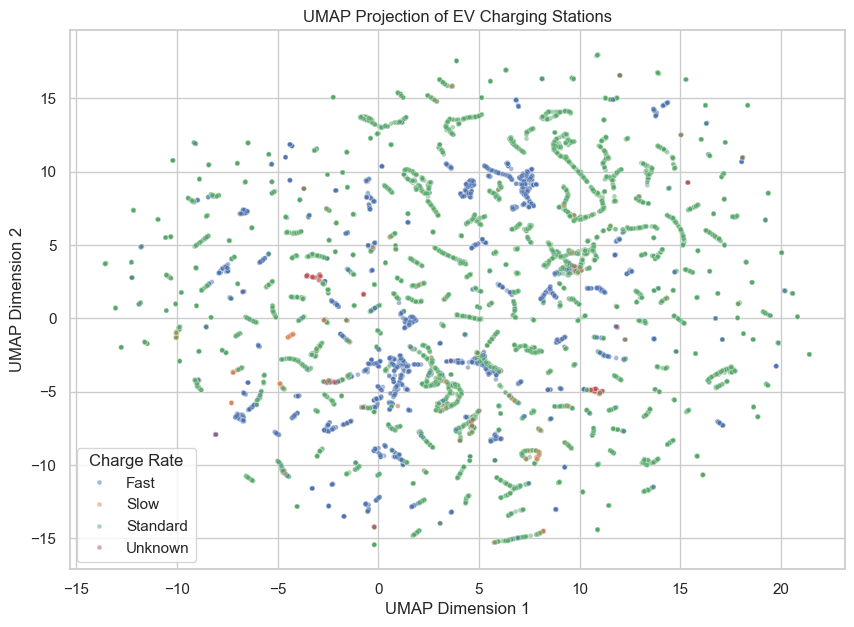

In [43]:
import numpy as np
import pandas as pd
import umap.umap_ as umap
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse


#Uniform Manifold Approximation and Projection (UMAP) is implemented here to lower the high dimensional feature space of EV charging stations into 2D for visualization. Before doing UMAP, numeric features were standardized, and categorical variables were reduced in cardinality and transformed using one-hot encoding. 

#Remove accidental whitespace in column names
dfSelect.columns = dfSelect.columns.str.strip()

# Make sure string-based columns are actually treated like strings
for c in ["Country", "City", "Charge Rate"]:
    if c in dfSelect.columns:
        dfSelect[c] = dfSelect[c].astype("string").str.strip()

drop_cols = [c for c in ["Station ID", "ID"] if c in dfSelect.columns]


# lower category size 
# only the K most frequent categories everything else is Other
def reduce_cardinality(series: pd.Series, top_k: int = 30, other_label: str = "Other") -> pd.Series:
    s = series.astype("string").fillna(other_label).str.strip()
    top = s.value_counts().head(top_k).index
    return s.where(s.isin(top), other_label)

TOP_K_COUNTRY = 30
TOP_K_CITY = 50

dfSelect["Country_reduced"] = reduce_cardinality(dfSelect["Country"], top_k=TOP_K_COUNTRY) if "Country" in dfSelect.columns else "Other"
dfSelect["City_reduced"] = reduce_cardinality(dfSelect["City"], top_k=TOP_K_CITY) if "City" in dfSelect.columns else "Other"


label_col = "Charge Rate" if "Charge Rate" in dfSelect.columns else None
if label_col is not None:
    dfSelect[label_col] = dfSelect[label_col].astype("category")


# Build X for UMAP

X = dfSelect.drop(columns=drop_cols, errors="ignore").copy()

#have remove this to avoid data leakage
if label_col is not None and label_col in X.columns:
    X = X.drop(columns=[label_col], errors="ignore")

# Remove very high-cardinality text columns 
high_card_text = [c for c in ["ConnectionTypes", "Address", "Station Name", "Name", "Operator", "Description"] if c in X.columns]
X = X.drop(columns=high_card_text, errors="ignore")

categorical_cols = [c for c in ["Country_reduced", "City_reduced"] if c in X.columns]
numeric_cols = X.select_dtypes(include=["number", "bool"]).columns.tolist()

print("Feature matrix shape before transform:", X.shape)
print("Numeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)


#sample data for visualization-

N_SAMPLE = min(20000, len(X))
sample_idx = X.sample(n=N_SAMPLE, random_state=42).index

X_s = X.loc[sample_idx].copy()
labels_s = dfSelect.loc[sample_idx, label_col].copy() if label_col is not None else None



preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=True), categorical_cols),
    ],
    remainder="drop"
)

X_processed = preprocessor.fit_transform(X_s)

if not sparse.issparse(X_processed):
    X_processed = sparse.csr_matrix(X_processed)
else:
    X_processed = X_processed.tocsr()

X_processed = X_processed.astype(np.float32)

print("Processed matrix shape:", X_processed.shape)

umap_model = umap.UMAP( 

    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    metric="euclidean",
    random_state=42,
    n_jobs=1
)

X_umap = umap_model.fit_transform(X_processed)

df_umap = pd.DataFrame({
    "UMAP_1": X_umap[:, 0],
    "UMAP_2": X_umap[:, 1],
})

if labels_s is not None:
    df_umap["Charge Rate"] = labels_s.values

plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=df_umap,
    x="UMAP_1",
    y="UMAP_2",
    hue="Charge Rate" if labels_s is not None else None,
    alpha=0.5,
    s=12
)

plt.title("UMAP Projection of EV Charging Stations")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.legend(title="Charge Rate", loc="best")
plt.show()



### Analysis

It is observable that standard EV charger installation is prelevant, while there is some pockets of Fast EV charger installation visiable.